## Dataset for work with Noe on spirals

In [3]:
import sys,os
sys.path.append('../')

# General
import glob
import os.path
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib.colors import Normalize
# from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import pandas as pd

# Data treatment
import dask as da
from dask.diagnostics import ProgressBar
import zarr
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from datetime import datetime

# Custom
import functions as f
# import plotUtils as pu

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [4]:
PTHS = {
    'sar_pth': '/home/arthur/results/sar_extended/05_addPRIMED/dsg.nc',
}

### Open data
dsg  = xr.open_dataset(PTHS['sar_pth'])

In [21]:
sam = dsg.where(dsg.name == 'SAM', drop=True).isel(time=1)
print(sam.file.item())
# s1b-ew-owi-cm-20210926t090903-20210926t091107-000003-0371EC_sw.nc

s1b-ew-owi-cm-20210926t090903-20210926t091107-000003-0371EC_sw.nc


In [30]:
lee = dsg.where(dsg.name == 'LEE', drop=True).isel(time=2)
print(lee.file.item())
# s1a-ew-owi-cm-20230908t092521-20230908t092624-000003-060BF1_sw.nc

s1a-ew-owi-cm-20230908t092521-20230908t092624-000003-060BF1_sw.nc


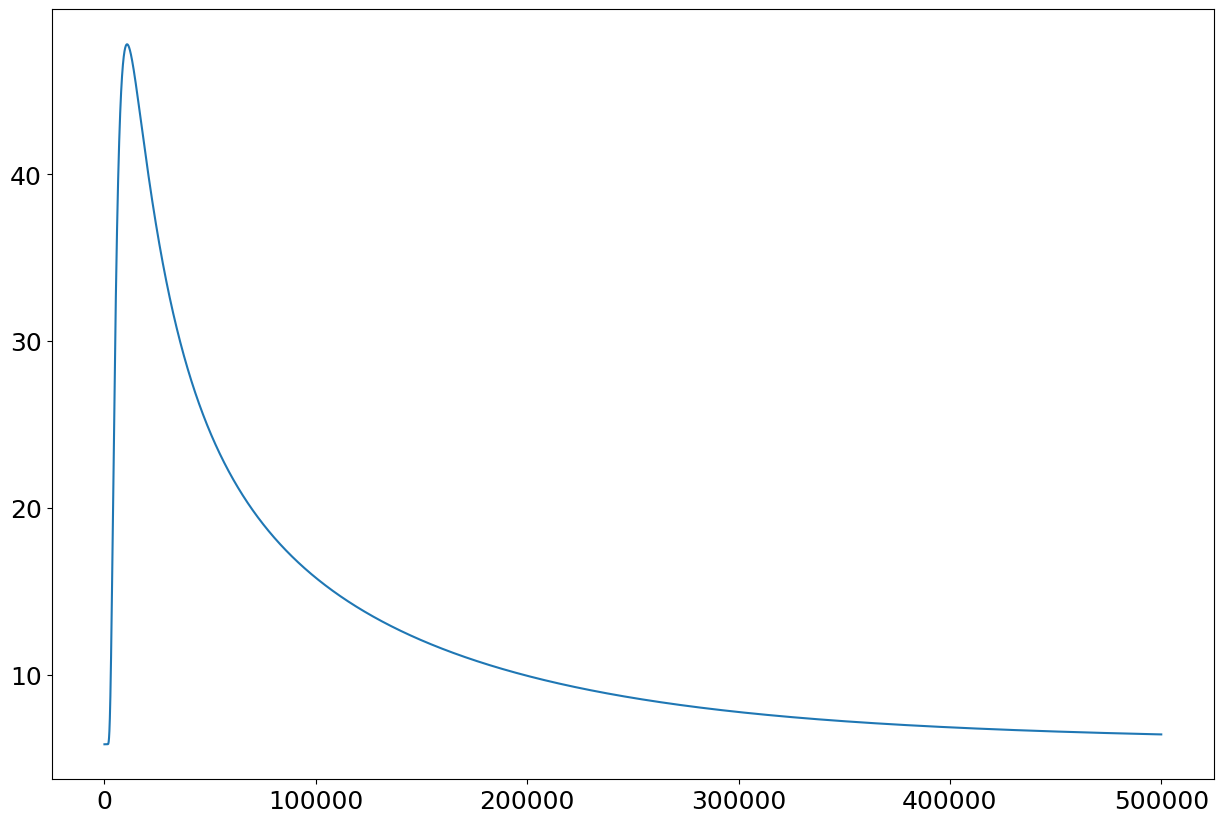

In [83]:
# Functions
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001              # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

# Reference grid
rs   = np.linspace(0, 500000, 50001)

# Parameters
lat  = float(sam.lat)
B    = float(sam.B_hol)
Vmin = float(sam.vmn_hol)
Rmax = float(sam.rmx_hol)
Vmax = float(sam.vmx_hol)

# Plot
plt.plot(rs, holland_profile(rs, lat, B, Vmin, Rmax, Vmax))

In [80]:
subset = ['lat', 'lon', 'B_hol', 'vmn_hol', 'rmx_hol', 'vmx_hol']

sam[subset].to_netcdf('/home/arthur/results/TCsLifeMonitFromObs/PRJCT_STEADY_STATE_CRIT/COLLABS/PARAMS_{}.nc'.format(sam.file.item().item()))
lee[subset].to_netcdf('/home/arthur/results/TCsLifeMonitFromObs/PRJCT_STEADY_STATE_CRIT/COLLABS/PARAMS_{}.nc'.format(lee.file.item().item()))